<a href="https://colab.research.google.com/github/helioRocha/programming-4-finance/blob/master/Predicting_Stock_Prices_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##[NeuralNine: Predicting Stock Prices in Python](https://youtu.be/PuZY9q-aKLw)

> **DISCLAIMER**: This is not investing advice, just an exercise. I am not yet a professional who is qualified in giving any financial advice. This is a notebook purely about programming using financial data. Original lesson by NeuralNine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


#### Load Data

In [2]:
company_stock_symbol = 'T'


In [3]:
start, end = dt.datetime(2011,1,1), dt.datetime(2021,1,1)
source = 'yahoo'

data = web.DataReader(company_stock_symbol, 
                      source, 
                      start, 
                      end)


### Prepare Data for NN

In [4]:
scaler = MinMaxScaler(feature_range=(0,1)) # to fit values between 0 and 1
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60 # How many past days I want to base my prediction on (next day)

x_train = [scaled_data[x-prediction_days:x, 0] for x in range(prediction_days, len(scaled_data))]
y_train = [scaled_data[x, 0] for x in range(prediction_days, len(scaled_data))]

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


####Build the Model

In [5]:
model = Sequential()

model.add(LSTM(units=50, 
               return_sequences=True, 
               input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next closing value

model.compile(optimizer='adam', 
              loss='mean_squared_error')
model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size=32)


Epoch 1/25
77/77 [==============================] - 12s 87ms/step - loss: 0.0202
Epoch 2/25
77/77 [==============================] - 7s 87ms/step - loss: 0.0067
Epoch 3/25
77/77 [==============================] - 7s 86ms/step - loss: 0.0055
Epoch 4/25
77/77 [==============================] - 7s 87ms/step - loss: 0.0052
Epoch 5/25
77/77 [==============================] - 7s 86ms/step - loss: 0.0047
Epoch 6/25
77/77 [==============================] - 7s 87ms/step - loss: 0.0048
Epoch 7/25
77/77 [==============================] - 7s 87ms/step - loss: 0.0042
Epoch 8/25
77/77 [==============================] - 7s 88ms/step - loss: 0.0039
Epoch 9/25
77/77 [==============================] - 7s 88ms/step - loss: 0.0037
Epoch 10/25
77/77 [==============================] - 7s 88ms/step - loss: 0.0037
Epoch 11/25
77/77 [==============================] - 7s 89ms/step - loss: 0.0035
Epoch 12/25
77/77 [==============================] - 7s 89ms/step - loss: 0.0033
Epoch 13/25
77/77 [=================

####Test the Model Accuracy on Existing Data

In [6]:
# Load Test Data
test_start, test_end = dt.datetime(2020,1,1), dt.datetime.now()

test_data = web.DataReader(company_stock_symbol, 
                           source, 
                           test_start, 
                           test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


####Make Predictions on Test Data

In [7]:
x_test = [model_inputs[x-prediction_days:x, 0] for x in range(prediction_days, len(model_inputs))]
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


####Plot the Test Predictions

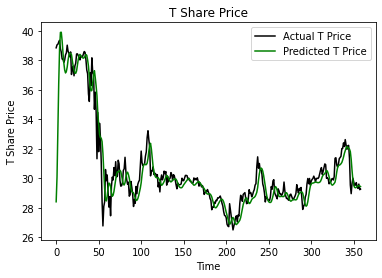

In [8]:
plt.plot(actual_prices, color="black", label=f"Actual {company_stock_symbol} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company_stock_symbol} Price")
plt.title(f"{company_stock_symbol} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company_stock_symbol} Share Price')
plt.legend()
plt.show()


####Predict Next Day

In [9]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")


Prediction: [[29.372122]]
